In [6]:
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
from PIL import Image
import seaborn as sns
import tensorflow as tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [49]:
data_loc_train = '../data/train/'
train_dir = pathlib.Path(data_loc_train).with_suffix('')
test_loc = '../data/test/'
test_dir = pathlib.Path(test_loc).with_suffix('')
image_count = len(list(train_dir.glob('*/*.jpeg')))
print(image_count)

5216


In [52]:
batch_size = 32
img_height = 300
img_width = 300
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


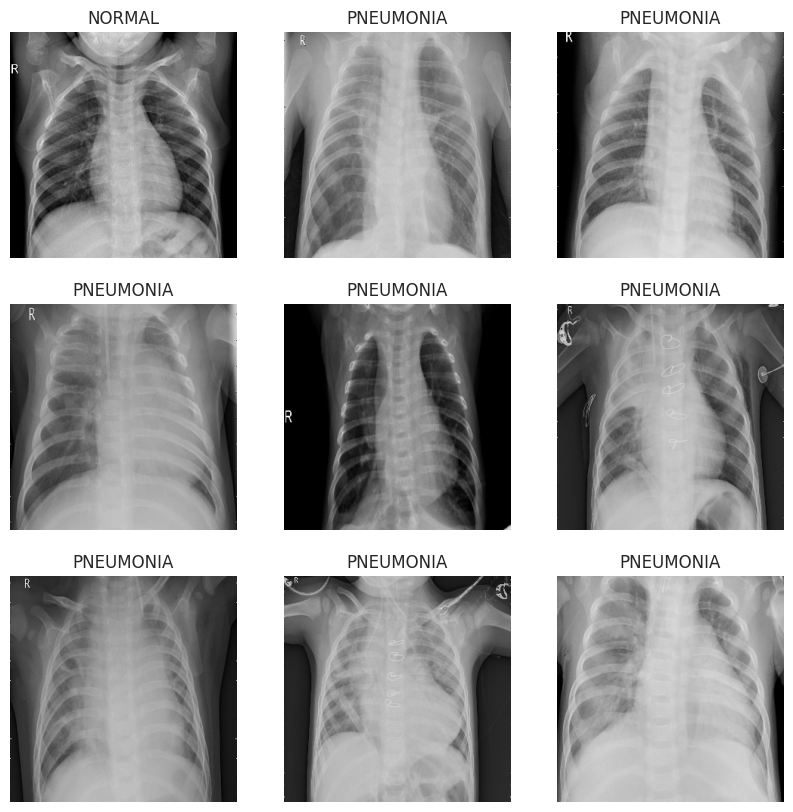

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [54]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.036392134 0.8669334


In [75]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(32, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(16, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  # tf.keras.layers.Conv2D(16, 3, activation='relu'),
  # tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [76]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=1_000,
  callbacks=[callback]
)

Epoch 1/1000


2024-01-27 15:48:16.427960: W external/local_tsl/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 346.89MiB (rounded to 363741184)requested by op AddV2
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-01-27 15:48:16.428006: I external/local_tsl/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2024-01-27 15:48:16.428016: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 404, Chunks in use: 404. 101.0KiB allocated for chunks. 101.0KiB in use in bin. 22.2KiB client-requested in use in bin.
2024-01-27 15:48:16.428022: I external/local_tsl/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 41, Chunks in use: 41. 20.8KiB allocated for chunks. 20.8KiB in use in bin. 20.5KiB client-requested in use in bin.
2024-01-27 15:48:1

ResourceExhaustedError: in user code:

    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/rafael/git/ml-practice/venv/lib/python3.10/site-packages/keras/src/backend.py", line 2100, in random_uniform
        return tf.random.stateless_uniform(

    ResourceExhaustedError: Exception encountered when calling layer 'sequential_15' (type Sequential).
    
    {{function_node __wrapped__AddV2_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:AddV2] name: 
    
    Call arguments received by layer 'sequential_15' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 300, 300, 3), dtype=float32)
      • training=True
      • mask=None


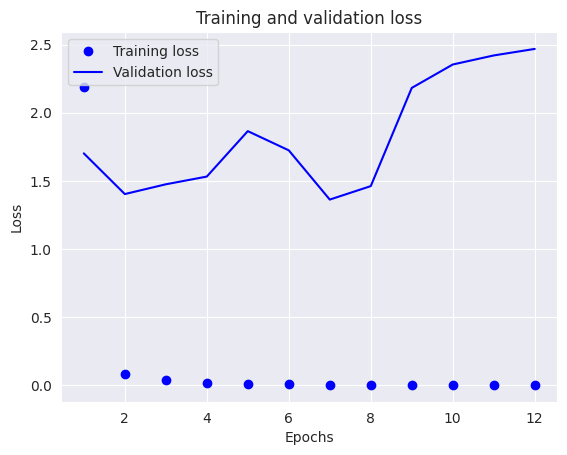

In [68]:
history_dict = history.history
history_dict.keys()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

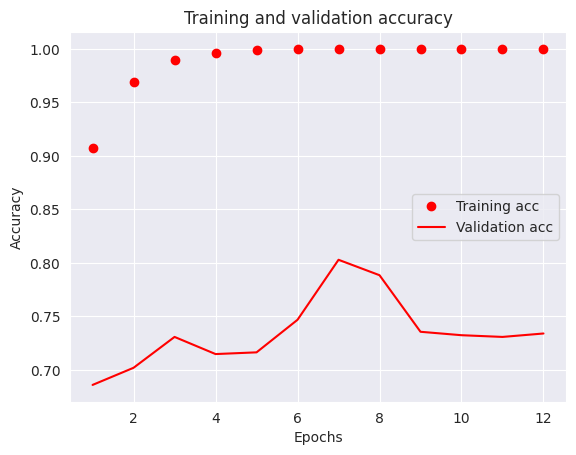

In [69]:
plt.plot(epochs, acc, 'ro', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='right')

plt.show()